In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
defending_csv = "cleaned_data/defending_cleaned.csv"
passing_csv = "cleaned_data/passing_cleaned.csv"
standard_csv = "cleaned_data/standard_cleaned.csv"

df_def = pd.read_csv(defending_csv)
df_pass = pd.read_csv(passing_csv)
df_std = pd.read_csv(standard_csv)

In [38]:
print("Defending columns:", df_def.columns.tolist())
print("Passing columns:", df_pass.columns.tolist())
print("Standard columns:", df_std.columns.tolist())

Defending columns: ['Rk', 'Player', 'Nation', 'Pos', 'Squad', 'Comp', 'Age', 'Born', '90s', 'Tkl', 'TklW', 'Def 3rd', 'Mid 3rd', 'Att 3rd', 'DribTkl', 'Att', 'Tkl%', 'Lost', 'Blocks', 'Sh', 'Pass', 'Int', 'Tkl+Int', 'Clr', 'Err', 'Matches', 'Season', 'Interceptions/90', 'Tackles/90']
Passing columns: ['Rk', 'Player', 'Nation', 'Pos', 'Squad', 'Comp', 'Age', 'Born', '90s', 'Cmp_Total', 'Att_Total', 'Cmp%_Total', 'TotDist', 'PrgDist', 'Cmp_Short', 'Att_Short', 'Cmp%_Short', 'Cmp_Medium', 'Att_Medium', 'Cmp%_Medium', 'Cmp_Long', 'Att_Long', 'Cmp%_Long', 'Ast', 'xAG', 'xA', 'A-xAG', 'KP', '1/3', 'PPA', 'CrsPA', 'PrgP', 'Matches', 'Season', 'Cmp_Total/90', 'Cmp_Short/90', 'Cmp_Medium/90', 'Cmp_Long/90', 'Att_Total/90', 'Att_Short/90', 'Att_Medium/90', 'Att_Long/90']
Standard columns: ['Rk', 'Player', 'Nation', 'Pos', 'Squad', 'Comp', 'Age', 'Born', 'MP', 'Starts', 'Min', '90s', 'Gls', 'Ast', 'G+A', 'G-PK', 'PK', 'PKatt', 'CrdY', 'CrdR', 'xG', 'npxG', 'xAG', 'npxG+xAG', 'PrgC', 'PrgP', 'PrgR

In [39]:
for df in [df_def, df_pass, df_std]:
    if 'Competition' in df.columns:
        df.rename(columns={'Competition': 'Comp'}, inplace=True)

In [40]:
for df in [df_def, df_pass, df_std]:
    if 'Competition' in df.columns:
        df.rename(columns={'Competition': 'Comp'}, inplace=True)
    if 'Age' in df.columns:
        df['Age'] = pd.to_numeric(df['Age'], errors='coerce')

In [41]:
merge_keys = ['Player', 'Season', 'Nation', 'Pos', 'Squad', 'Comp', 'Age']

# Merge defending + passing
df_merged = pd.merge(df_def, df_pass, on=merge_keys, suffixes=('_def', '_pass'), how='inner')
# Merge with standard
df_merged = pd.merge(df_merged, df_std, on=merge_keys, suffixes=('', '_std'), how='inner')

print("Merged shape:", df_merged.shape)

Merged shape: (19564, 95)


In [42]:
drop_cols = ['Nation', 'Comp', 'Born']  # Add more as needed
df_final = df_merged.drop(columns=[col for col in drop_cols if col in df_merged.columns])

In [43]:
# Identify non-numeric columns to exclude
non_numeric = ['Player', 'Season', 'Pos', 'Squad', 'Age']
feature_cols = [col for col in df_final.columns if col not in non_numeric and pd.api.types.is_numeric_dtype(df_final[col])]

# Final feature matrix for clustering
X = df_final[feature_cols].copy()

In [44]:
# Check for inf/-inf and replace with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Option 1: Drop rows with NaN (if you want only complete cases)
X = X.dropna()

# Option 2: Or fill NaN with 0 or column mean (choose what makes sense for your use case)
# X = X.fillna(0)
# X = X.fillna(X.mean())

# Now scale
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

print(X.isnull().sum())
print(np.isinf(X).sum())

Born_def          0
90s_def           0
Tkl               0
TklW              0
Def 3rd           0
                 ..
xG_per90          0
xAG_per90         0
xG+xAG_per90      0
npxG_per90        0
npxG+xAG_per90    0
Length: 68, dtype: int64
Born_def          0
90s_def           0
Tkl               0
TklW              0
Def 3rd           0
                 ..
xG_per90          0
xAG_per90         0
xG+xAG_per90      0
npxG_per90        0
npxG+xAG_per90    0
Length: 68, dtype: int64


In [45]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

In [46]:
def prepare_player_clustering_df(
    defending_csv="cleaned_data/defending_cleaned.csv",
    passing_csv="cleaned_data/passing_cleaned.csv",
    standard_csv="cleaned_data/standard_cleaned.csv",
    drop_cols=None,
    scale_method="zscore"
):
    """
    Loads, merges, and prepares player-level stats for clustering.

    Returns:
        df_final: DataFrame with identifiers and features
        X_scaled: Standardized feature matrix (for clustering)
    """
    # Load
    df_def = pd.read_csv(defending_csv)
    df_pass = pd.read_csv(passing_csv)
    df_std = pd.read_csv(standard_csv)

    # Harmonize column names and ensure Age is numeric
    for df in [df_def, df_pass, df_std]:
        if 'Competition' in df.columns:
            df.rename(columns={'Competition': 'Comp'}, inplace=True)
        if 'Age' in df.columns:
            df['Age'] = pd.to_numeric(df['Age'], errors='coerce')

    merge_keys = ['Player', 'Season', 'Nation', 'Pos', 'Squad', 'Comp', 'Age']

    # Merge
    df_merged = pd.merge(df_def, df_pass, on=merge_keys, suffixes=('_def', '_pass'), how='inner')
    df_merged = pd.merge(df_merged, df_std, on=merge_keys, suffixes=('', '_std'), how='inner')

    # Drop unwanted columns
    if drop_cols is None:
        drop_cols = ['Nation', 'Comp', 'Born']
    df_final = df_merged.drop(columns=[col for col in drop_cols if col in df_merged.columns])

     # Identify features
    non_numeric = ['Player', 'Season', 'Pos', 'Squad', 'Age']
    feature_cols = [col for col in df_final.columns if col not in non_numeric and pd.api.types.is_numeric_dtype(df_final[col])]

    # Clean inf/-inf and NaN values before scaling
    X = df_final[feature_cols].copy()
    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    X = X.dropna()  # or use X = X.fillna(0) or X = X.fillna(X.mean()) if you prefer

    # Standardize
    from sklearn.preprocessing import StandardScaler, MinMaxScaler
    scaler = StandardScaler() if scale_method == "zscore" else MinMaxScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=feature_cols, index=X.index)

    # Optionally, align df_final to X (if you dropped rows)
    df_final = df_final.loc[X.index]

    return df_final, X_scaled

In [47]:
df_final, X_scaled = prepare_player_clustering_df()

print(df_final[['Player', 'Season', 'Squad', 'Pos']].head())
print(X_scaled.head())

                Player     Season           Squad    Pos
0  Patrick van Aanholt  2017-2018  Crystal Palace     DF
1       Rolando Aarons  2017-2018   Newcastle Utd  MF,FW
2       Rolando Aarons  2017-2018   Hellas Verona  MF,FW
3        Ignazio Abate  2017-2018           Milan     DF
4      Aymen Abdennour  2017-2018       Marseille     DF
   Born_def   90s_def       Tkl      TklW   Def 3rd   Mid 3rd   Att 3rd  \
0 -0.887170  0.914451  1.189762  1.417901  1.601626  0.697973  0.131686   
1  0.122956 -1.187098 -0.815077 -0.676742 -0.635751 -0.806954 -0.824984   
2  0.122956 -0.799970 -0.395460 -0.377507 -0.549698 -0.484469  0.769466   
3 -1.695271 -0.246931 -0.069091  0.295771 -0.033380  0.053004 -0.506094   
4 -1.089196 -0.818405 -0.675205 -0.751551 -0.463645 -0.699459 -0.824984   

        Att      Tkl%      Lost  ...  Gls_per90  Ast_per90  G+A_per90  \
0  0.613806  0.355132  0.495961  ...   0.383093  -0.137209   0.117691   
1 -0.721924  1.125005 -0.791778  ...  -0.456260  -0.257925  -

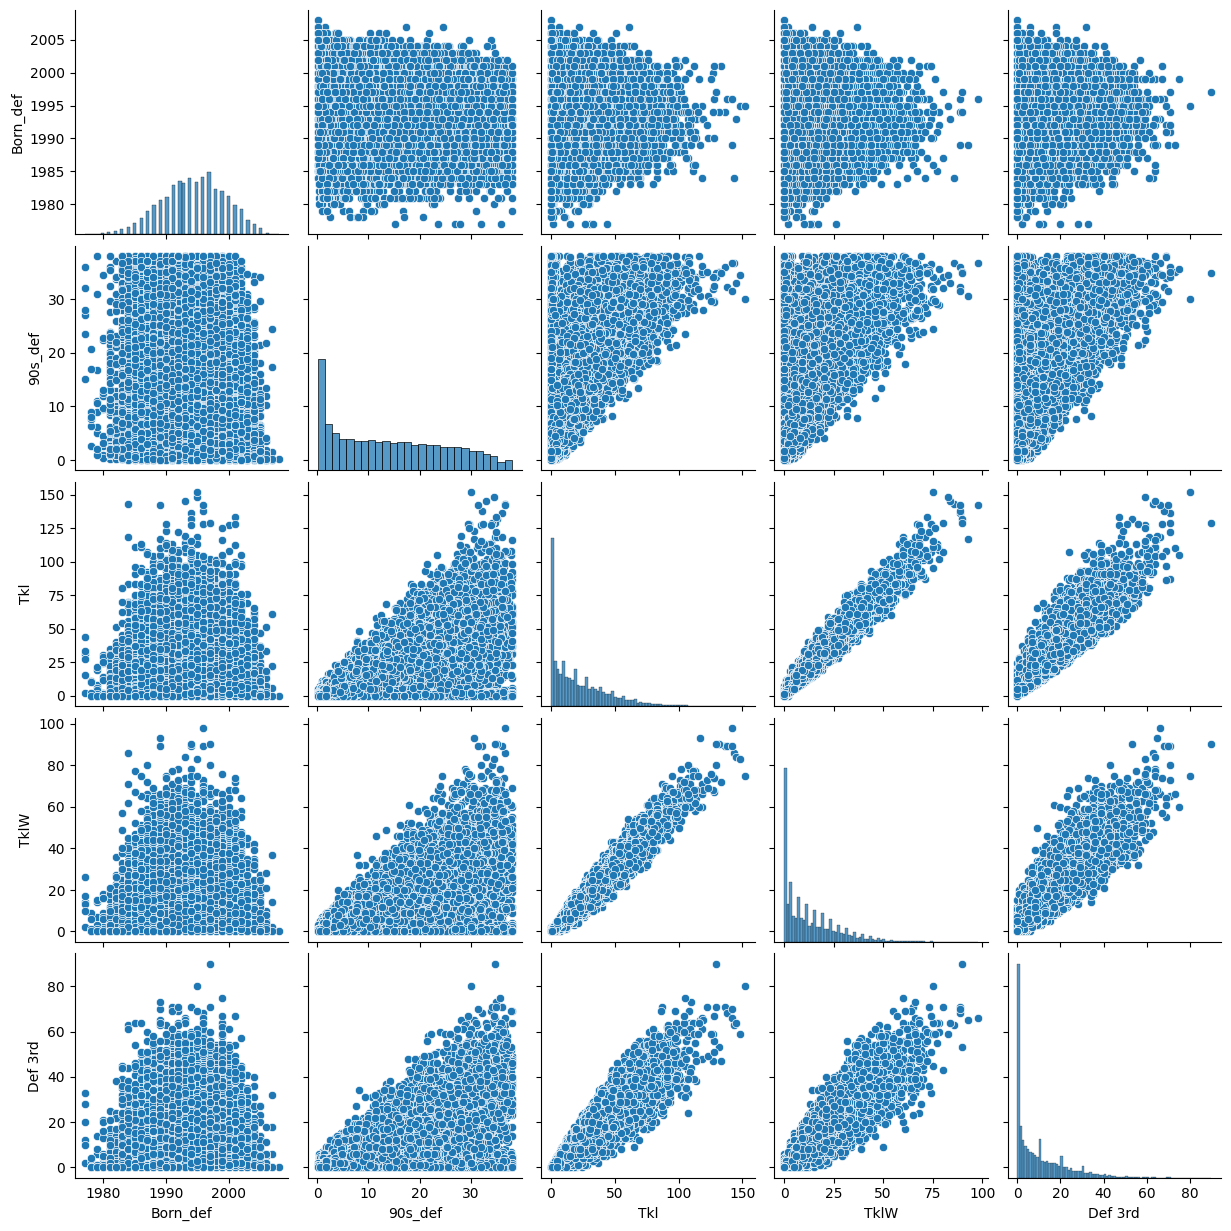

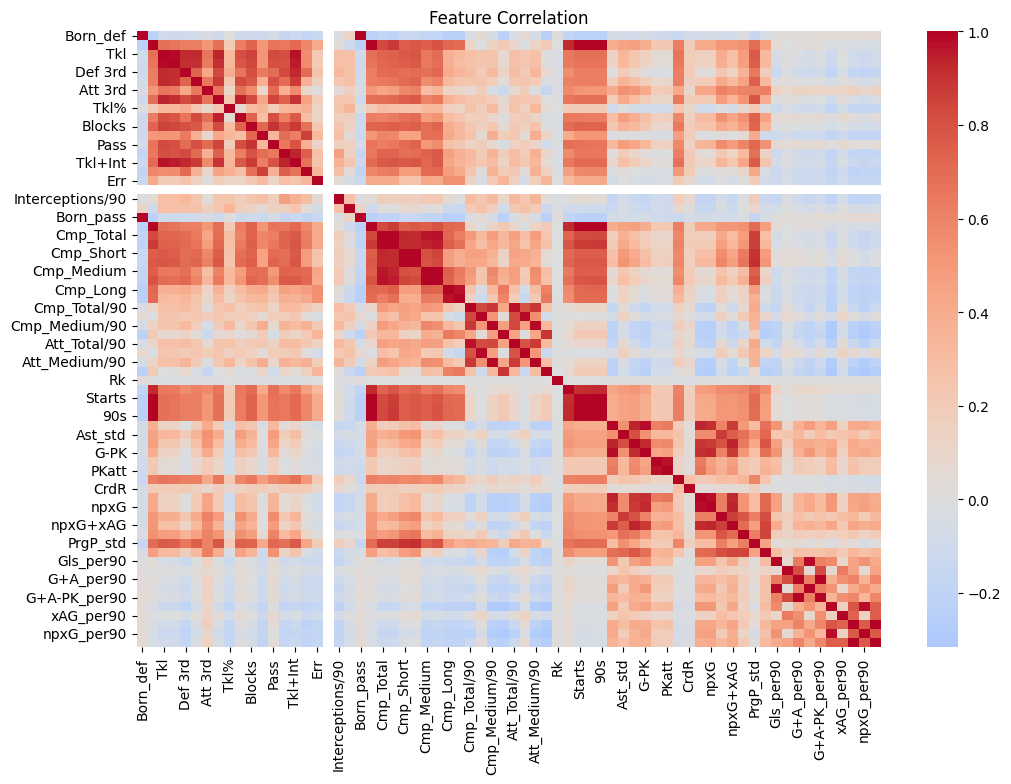

In [48]:
# Pairplot of a few features
sns.pairplot(df_final, vars=X_scaled.columns[:5])
plt.show()

# Correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(X_scaled.corr(), cmap='coolwarm', center=0)
plt.title("Feature Correlation")
plt.show()

In [ ]:
from sklearn.cluster import KMeans

# Choose number of clusters (k)
k = 6  #using 5 for now

kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

In [50]:
df_final['cluster'] = clusters

In [51]:
cluster_profiles = df_final.groupby('cluster')[X_scaled.columns].mean()
print(cluster_profiles)

            Born_def    90s_def        Tkl       TklW    Def 3rd    Mid 3rd  \
cluster                                                                       
0        1995.640651   3.822328   5.046259   3.029720   2.242150   2.033855   
1        1993.612890  27.379376  59.082328  35.888981  27.372973  24.775052   
2        1993.939401  14.811751  26.989574  16.437446  13.500652  10.579279   
3        1992.893241  27.283196  40.147189  24.850916  25.926721  12.561592   
4        1993.983003  22.249811  20.691218  12.253069   6.108121   9.333333   
5        1991.266078  28.681589   0.720050   0.388398   0.711223   0.007566   

          Att 3rd        Att       Tkl%       Lost  ...  Gls_per90  Ast_per90  \
cluster                                             ...                         
0        0.770255   5.212689  30.407624   3.175475  ...   0.091743   0.068358   
1        6.934304  58.468191  44.574927  32.725156  ...   0.081767   0.108832   
2        2.909644  26.321677  47.151520  14

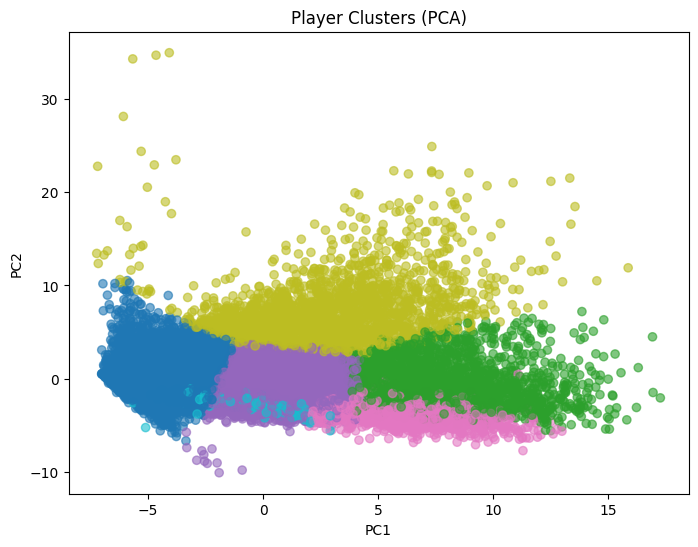

In [52]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, cmap='tab10', alpha=0.6)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Player Clusters (PCA)')
plt.show()

In [53]:
# Show first 10 players in each cluster
for c in sorted(df_final['cluster'].unique()):
    print(f"\nCluster {c}:")
    print(df_final[df_final['cluster'] == c][['Player', 'Season', 'Squad', 'Pos']].head(10))


Cluster 0:
              Player     Season          Squad    Pos
1     Rolando Aarons  2017-2018  Newcastle Utd  MF,FW
2     Rolando Aarons  2017-2018  Hellas Verona  MF,FW
4    Aymen Abdennour  2017-2018      Marseille     DF
5          Aly Abeid  2017-2018        Levante     DF
12      Charlie Adam  2017-2018     Stoke City     MF
18       Yacine Adli  2017-2018      Paris S-G     FW
22   Ibrahim Afellay  2017-2018     Stoke City     MF
23       Benik Afobe  2017-2018    Bournemouth     FW
25  Imanol Agirretxe  2017-2018  Real Sociedad     FW
30            Ailton  2017-2018      Stuttgart  DF,MF

Cluster 1:
                   Player     Season           Squad    Pos
0     Patrick van Aanholt  2017-2018  Crystal Palace     DF
27          Ruben Aguilar  2017-2018     Montpellier     DF
29      Jean-Eudes Aholou  2017-2018      Strasbourg     MF
31  Youssef Aït Bennasser  2017-2018            Caen     MF
41             Jordi Alba  2017-2018       Barcelona     DF
46        Marc Albrigh

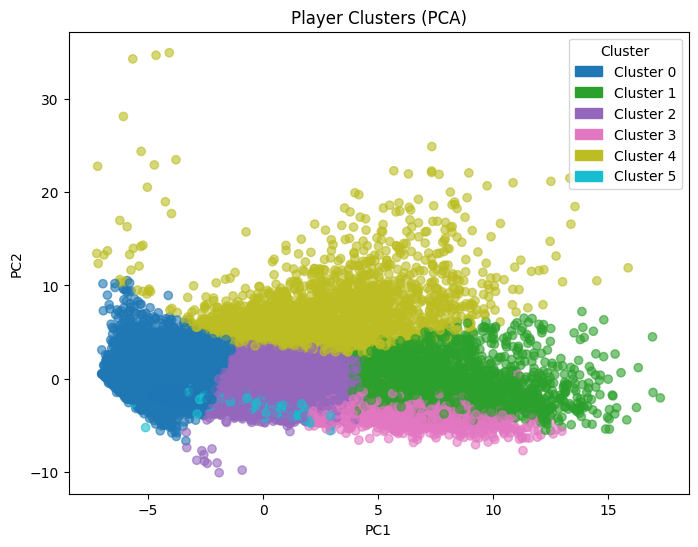

In [54]:
import matplotlib.patches as mpatches

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, cmap='tab10', alpha=0.6)

# Create legend: one color per cluster
handles = []
unique_clusters = np.unique(clusters)
cmap = plt.get_cmap('tab10', len(unique_clusters))  # <-- fixed here
for i, cluster_num in enumerate(unique_clusters):
    handles.append(mpatches.Patch(color=cmap(i), label=f'Cluster {cluster_num}'))

plt.legend(handles=handles, title="Cluster")
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Player Clusters (PCA)')
plt.show()